# Comparing Spectra
In this notebook, we will plot the spectral intensity against the polarized spectra of different stars of a particular type and rotational velocity. To fetch and query data, we will use the `astroquery` package, particularly the CADC and Vizier modules.

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
    * [2.1 Using pip](#2.1-Using-pip)
    * [2.2 From source](#2.2-From-source)
* [3. Querying](#3.-Querying)
    * [3.1 Querying the VizieR Catalog](#3.1-Querying-the-VizieR-Catalog)
    * [3.2 Defining Search Parameters](#3.2-Defining-Search-Parameters)
    * [3.3 Querying CADC using ADQL](#3.3-Querying-CADC-using-ADQL)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Plotting Results](#5.-Plotting-Results)

## 1. Introduction
The [Bright Star Catalog](http://adsabs.harvard.edu/abs/1995yCat.5050....0H) (BSC) is an open data collection with basic astronomical information of stars brighter than magnitude 6.5. 

## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed in two ways:

### 2.1 Using pip
The CADC module is only available with the pre-release of the astroquery module, and can be installed using the command:

```
    pip install --pre --upgrade astroquery
```

### 2.2 From source
Alternatively, you can clone and install from the source:
```
    # If you have a github account:
    git clone git@github.com:astropy/astroquery.git
    # If you do not:
    git clone https://github.com/astropy/astroquery.git
    cd astroquery
    python setup.py install
```
Note that these commands can also be done in a Jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`. More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery). 

## 3. Querying
In order to get the stars that we want to look at and the spectra of those stars, we will have to do two queries: one of the Bright Star Catalog and the other of the CADC database.

### 3.1 Querying the VizieR Catalog
In order to query the BSC, we will use the [VizieR database](http://vizier.cfa.harvard.edu/) which is a library of published astronomical catalogs. Through VizieR, we can access and query the 5th Revised Ed. of the BSC. In this tutorial, we want stars of [spectral type 'B'](https://en.wikipedia.org/wiki/Stellar_classification#Class_B) and rotation velocity less than 20 km/s. Type 'B' stars B	have surface temp in the range 10,000-25,000K and have distinguishing features H, HeI, with HeII absent (https://www.cfa.harvard.edu/~pberlind/atlas/htmls/note.html).

In [1]:
from astroquery.vizier import Vizier

# Get the catalog name of the 5th Revised Ed. of the Bright Star Catalog
catalog_list = Vizier.find_catalogs('Bright Star Catalogue, 5th Revised Ed.')
print({k: v.description for k, v in catalog_list.items()})
catalog_key = list(catalog_list.keys())[0]
catalog = Vizier.get_catalogs(catalog_key)
catalog_name = catalog.keys()[0]

# Increase the row limit and query the catalog
Vizier.ROW_LIMIT = 200
result = Vizier.query_constraints(catalog=catalog_name,
                                  SpType='B*',
                                  RotVel='<20',
                                  row_limit=200)
bright_star_results = result[catalog_name]
bright_star_results

{'V/50': 'Bright Star Catalogue, 5th Revised Ed. (Hoffleit+, 1991)'}


HR,Name,HD,ADS,VarID,RAJ2000,DEJ2000,Vmag,B-V,SpType,NoteFlag
,,,,,"""h:m:s""","""d:m:s""",mag,mag,,
int16,bytes10,int32,bytes5,bytes9,bytes10,bytes9,float32,float32,bytes20,bytes1
39,88Gam Peg,886,,Gam Peg,00 13 14.2,+15 11 01,2.83,-0.23,B2IV,*
62,,1279,,,00 17 09.1,+47 56 51,5.89,-0.09,B7III,
153,17Zet Cas,3360,,225,00 36 58.3,+53 53 49,3.66,-0.20,B2IV,*
208,23 Cas,4382,,,00 47 46.1,+74 50 51,5.41,-0.08,B8III,*
280,Alp Scl,5737,,359,00 58 36.4,-29 21 27,4.31,-0.16,B7IIIp,*
465,,9996,,GY And,01 38 31.7,+45 24 00,6.36,0.04,B9pCrEu,*
542,45Eps Cas,11415,,652,01 54 23.7,+63 40 12,3.38,-0.15,B3III,*
562,,11905,,,01 57 56.4,+41 41 40,6.78,-0.06,B8III,*


### 3.2 Defining Search Parameters

Now, we define the parameters needed to query the CADC data. We want to later do a spectral cutout, using a wavelength range of 6675Å to 6682Å. In order to do this, we want to make sure that each CADC result has energy bounds that overlap with the given wavelength range. We also want to make sure that the release date for the data products has already passed so we have access to the files, and we also need to make a list of coordinates in order to find the files.

In [2]:
import datetime
from astropy.coordinates import SkyCoord
from astropy import units as u

# Define energy bounds in Angstrom and convert to metres
def ang_to_m(x):
    return x * 1e-10


energy_bounds_ang = (6675, 6682)
energy_bounds_m = (ang_to_m(energy_bounds_ang[0]),
                   ang_to_m(energy_bounds_ang[1]))

# Grab todays date and time
today = datetime.datetime.now().strftime("%Y-%m-%d %X")

# Get RA, Dec, HD, and Spectral Type of each star
ra_list = bright_star_results['RAJ2000']
dec_list = bright_star_results['DEJ2000']
hd_list = bright_star_results['HD']
sp_type_list = bright_star_results['SpType']

# Build a list of skycoords from star RA and Dec
coords = [
    SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))
    for ra, dec in zip(ra_list, dec_list)
]

# Define radius of circle to search for intersection in degrees TODO: Check if actually in degrees
radius = 0.01

### 3.3 Querying CADC using ADQL

To query the CADC database, we loop through the coordinates of the stars from the BSC and run an ADQL query for each one, grabbing the first result returned. Also, we will add two columns to our query result: `target_hd`, which is the HD number of the star, and `sp_type` which is the spectral type of the star.

To query the CADC database, we will upload the 

In [3]:
from astropy.table import Column
from astropy.io import votable

# Uploading the table does not accept the '-' character so rename column B-V to remove it
bright_star_results.rename_column('B-V', 'B_V')

# Add RA and Dec columns that use the proper format for ADQL geometrical functions
ra_column = Column([coord.ra.degree for coord in coords], name='RA')
dec_column = Column([coord.dec.degree for coord in coords], name='DEC')
bright_star_results.add_column(ra_column)
bright_star_results.add_column(dec_column)

output_file = 'bright_star_results.xml'
votable.writeto(bright_star_results, output_file)

In [4]:
%%time
from astropy.table import unique
from astroquery.cadc import Cadc

cadc = Cadc()

column_list = ', '.join([
    'star_results.HR AS HR', 'star_results.HD AS HD', 'star_results.SpType AS SpType',
    'Observation.collection AS collection', 'Observation.instrument_name AS instrument_name', 
    'Observation.target_name AS target_name', 'Plane.productID AS productID', 
    'Plane.energy_bounds_samples AS energy_bounds_samples','Plane.dataProductType AS dataProductType',
    'Plane.dataRelease AS dataRelease', 'Plane.position_bounds AS position_bounds',
    'Plane.publisherID AS caomPublisherID'
])

query_params = {
    'instrument_name': 'ESPaDOnS',
    'radius': radius,
    'collection': 'CFHT',
    'prod_id': '%i',
    'wavelength_lower': energy_bounds_m[0],
    'wavelength_upper': energy_bounds_m[1],
    'data_release': today,
    'column_list': column_list,
}

query = '''SELECT {column_list} FROM tap_upload.bright_star_results as star_results 
JOIN caom2.Plane AS Plane
ON (INTERSECTS( CIRCLE('ICRS', star_results.RA, star_results.DEC, {radius}), Plane.position_bounds ) = 1)
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID
WHERE  ( Observation.instrument_name = '{instrument_name}'
    AND Observation.collection = '{collection}' 
    AND Plane.productID LIKE '{prod_id}' 
    AND INTERSECTS( INTERVAL( {wavelength_lower}, {wavelength_upper} ), Plane.energy_bounds_samples ) = 1 
    AND Plane.dataRelease <= '{data_release}'
    AND ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ) )
'''.format(column_list, **query_params)

job = cadc.run_query(query,
                     'sync',
                     upload_resource=output_file,
                     upload_table_name="bright_star_results")
espadons_results = job.get_results()

CPU times: user 532 ms, sys: 43.1 ms, total: 575 ms
Wall time: 1min 53s


In [5]:
print("Number of results before filtering on unique HD: {}".format(
    len(espadons_results)))

unique_espadons_results = unique(espadons_results, keys='HD')
unique_espadons_results.show_in_notebook(display_length=5)

Number of results before filtering on unique HD: 862


idx,HR,HD,SpType,collection,instrument_name,target_name,productID,energy_bounds_samples,dataProductType,dataRelease,position_bounds,caomPublisherID
,,,,,,,,m,,,deg,
0,39,886,B2IV,CFHT,ESPaDOnS,hd 886,1048298i,[[3.6899011230500005e-07 1.04803515625e-06]],spectrum,2009-04-30T00:00:00.000,[3.309188029741362 15.183360999883304 3.3087279702586123 15.183360999883304 3.30872796977487 15.183804999883309 3.3091880302251213 15.183804999883252],ivo://cadc.nrc.ca/CFHT?1048298/1048298i
1,153,3360,B2IV,CFHT,ESPaDOnS,hd 3360,1050186i,[[3.6908309936500003e-07 1.04806433105e-06]],spectrum,2009-04-30T00:00:00.000,[9.243209754604866 53.8966949994103 9.242456245395129 53.8966949994103 9.242456241391816 53.89713899941031 9.24320975860818 53.897138999410245],ivo://cadc.nrc.ca/CFHT?1050186/1050186i
2,542,11415,B3III,CFHT,ESPaDOnS,HD 11415,1168490i,[[3.69754608154e-07 1.04804418945e-06]],spectrum,2011-08-31T00:00:00.000,[28.59933351599855 63.66988899913083 28.598332484001457 63.66988899913083 28.598332476163797 63.6703329991309 28.599333523836208 63.6703329991309],ivo://cadc.nrc.ca/CFHT?1168490/1168490i
3,779,16582,B2IV,CFHT,ESPaDOnS,hd 16582,1048322i,[[3.6899841308600005e-07 1.0480587158200001e-06]],spectrum,2009-04-30T00:00:00.000,[39.870444996346215 0.32872199999754026 39.87088900365379 0.32872199999754026 39.87088900364393 0.32827799999754 39.87044499635607 0.32827799999754],ivo://cadc.nrc.ca/CFHT?1048322/1048322i
4,811,17081,B7V,CFHT,ESPaDOnS,HD 17081,781666i,[[3.69087402344e-07 1.0480628662100002e-06]],spectrum,2006-08-31T00:00:00.000,[41.03735365631997 -13.858694999893915 41.03735365675714 -13.859138999893922 41.03689634324286 -13.859138999893922 41.036896343680034 -13.858694999893856],ivo://cadc.nrc.ca/CFHT?781666/781666i
5,873,18296,B9pSi,CFHT,ESPaDOnS,HD18296,1940335i,[[3.6939529418900004e-07 1.04823791504e-06]],spectrum,2017-08-31T00:00:00.000,[44.3230945895673 31.934027999731928 44.32257141043272 31.934027999731985 44.32257140916924 31.934471999731933 44.323094590830785 31.934471999731933],ivo://cadc.nrc.ca/CFHT?1940335/1940335i
6,1753,34798,B3V,CFHT,ESPaDOnS,hd34798,946822i,[[3.69210998535e-07 1.04817480469e-06]],spectrum,2009-02-28T00:00:00.000,[79.82490111849259 -18.515499999855955 79.82490111909993 -18.515943999855963 79.82443288089956 -18.515943999855963 79.82443288150748 -18.515499999855955],ivo://cadc.nrc.ca/CFHT?946822/946822i
7,3439,74067,B9V,CFHT,ESPaDOnS,HD74067,1845674i,[[3.69392089844e-07 1.0482266845700002e-06]],spectrum,2017-02-28T00:00:00.000,[130.08045907323543 -40.2636389996357 130.08104092676413 -40.2636389996357 130.0810409286738 -40.26408299963571 130.08045907132635 -40.26408299963571],ivo://cadc.nrc.ca/CFHT?1845674/1845674i
8,3468,74575,B1.5III,CFHT,ESPaDOnS,hd 74575,1844602i,[[3.69479400635e-07 1.0482353515600002e-06]],spectrum,2017-02-28T00:00:00.000,[130.89865173430454 -33.18613899971871 130.89918226569566 -33.18613899971871 130.8991822670398 -33.186582999718716 130.89865173295982 -33.186582999718716],ivo://cadc.nrc.ca/CFHT?1844602/1844602i


## 4. Fetching Data
The purpose of the next block of code is to build the spectral cutout data access url for each of the data products. To do this, we use the datalink service, find the cutout definition, grab the access url, and append the cutout parameters to it. The result is a list of access urls with cutouts. We use the [pyvo library](https://pyvo.readthedocs.io/en/latest/) to access the Datalink service. This library is made for use with IVOA services.

In [6]:
from pyvo.dal.adhoc import DatalinkResults
from six.moves.urllib.parse import urlencode

cutout_urls = []
cutout_params = {
    'BAND': '{} {}'.format(energy_bounds_m[0], energy_bounds_m[1])
}
datalink_url = 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/datalink'
publisher_ids = unique_espadons_results['caomPublisherID']

for pid in publisher_ids:

    # Get datalink results
    datalink_results = DatalinkResults.from_result_url('{}?{}'.format(
        datalink_url, urlencode({'ID': pid})))

    # Get the first cutout service definition
    service_def = next(datalink_results.bysemantics('#cutout'))

    access_url = service_def.access_url.decode('ascii')
    service_params = service_def.input_params
    input_params = next({param.name: param.value} for param in service_params
                        if param.name == 'ID')
    input_params.update(cutout_params)
    cutout_urls.append('{}?{}'.format(access_url, urlencode(input_params)))

cutout_urls[0]

'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3ACFHT%2F1048298i.fits.gz&BAND=6.675000000000001e-07+6.682e-07'

Now we use the access urls to access the fits files and retrieve the data.

In [7]:
from astropy.io import fits

# TODO: Ask if we should remove this?
limit = 10
data_list = []
verbose = False

for url in cutout_urls[:limit]:
    with fits.open(url) as hdulist:
        if verbose:
            hdulist.info()
        data = hdulist[0].data
        data_list.append(data)

## 5. Plotting Results
Now we can plot the spectral data! 

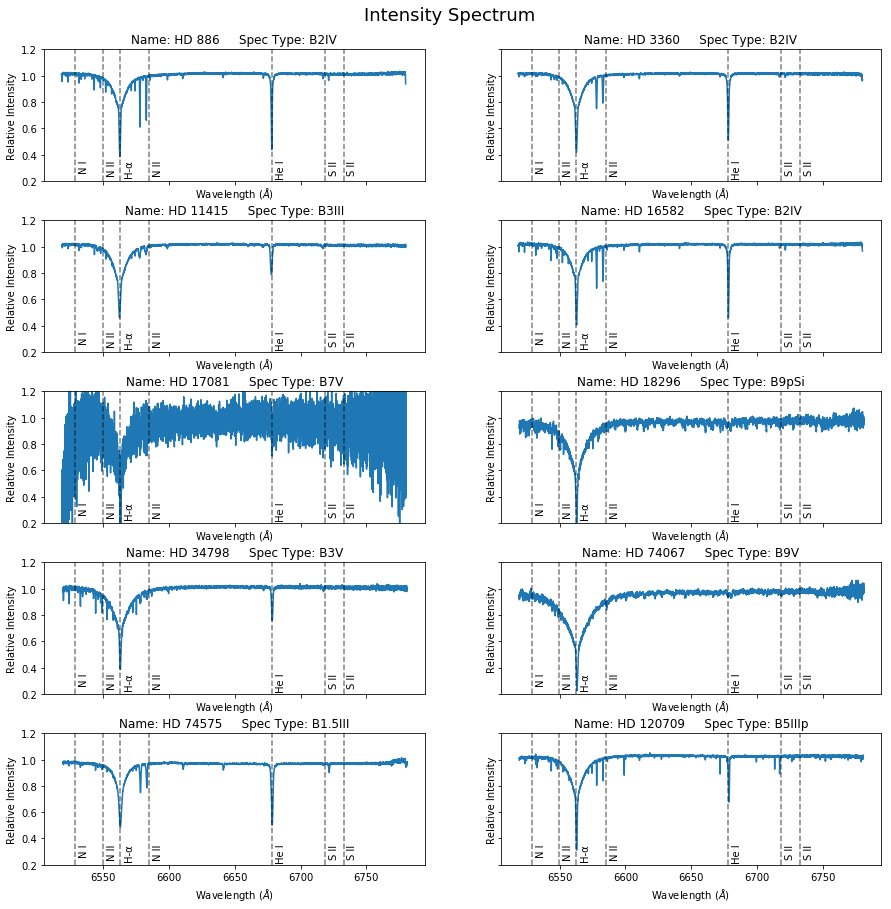

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
# Source: http://astro.uchicago.edu/~subbarao/newWeb/line.html
# Prominent spectral bands for B type stars He, H, O+, C+, N+, Si+
# neutral hydrogen lines, more prominent Balmer lines

hd_list = unique_espadons_results['HD'][:limit]
sp_list = unique_espadons_results['SpType'][:limit]

wavelength_list = [6529.03, 6549.86, 6585.27, 6718.29, 6732.67, 6562.8, 6678.1517]
element_list = ['N I', 'N II', 'N II', 'S II', 'S II', 'H-α', 'He I']

cols = 2
rows = math.ceil(len(data_list) / cols)
ylim = (0.2, 1.2)
xlim = (6675, 6682)
fig, axes = plt.subplots(rows, cols, figsize=(15, 15),
                         sharex=True, sharey=True)
plt.setp(axes, ylim=ylim)
for data, hd_name, sp_type, ax in zip(data_list, hd_list, sp_list,
                                      axes.flatten()):
    ax.plot(data[0]*10, data[1])
    #TODO: Ask if I should include spectral lines or not
    #TODO Add morex ticks
    
    ylim = ax.get_ylim()
    for wavelength, element in zip(wavelength_list, element_list):
        ax.axvline(x=wavelength, c='black', ls='--', alpha=0.5)
        ax.text(wavelength+3, ylim[0]+0.1, element,rotation=90)

    ax.set_title('Name: HD {}     Spec Type: {}'.format(
        hd_name, sp_type))
    ax.set_xlabel(r'Wavelength ($\AA$)')
    ax.set_ylabel('Relative Intensity')
#plt.setp(axes, xlim=xlim)

fig.suptitle('Intensity Spectrum', y=0.92, fontsize=18)
plt.subplots_adjust(hspace=0.3)
plt.show()

https://www.cfa.harvard.edu/~pberlind/atlas/htmls/note.html
    
## To decode the Spec Type...

| Luminosity Class | Description  | Comments              |
|------------------|--------------|-----------------------|
| 0                | Hypergiants  | extreme               |
| Ia               | Supergiants! | large and luminous    |
| Ib               | Supergiants! | less luminous than Ia |
| II	           | Bright Giants|                       |
| III	           | Giants       |                       |
| IV	           | Sub-Giants   |                       |
| V                | Dwarfs       | Main Sequence         |
| sd               | Sub-Dwarfs	  |                       |
| D                | White Dwarfs |                       |



| Peculiarity Code | Description                      |
|------------------|----------------------------------|
| comp             | composite spectrum               |
| e                | emission lines present           |
| f                | NIII and HeII emission (O stars) |
| m                | enhanced metal features          |
| n                | broad absorption features        |
| nn               | very broad absorption features   |
| neb              | nebular features present         |
| p                | other peculiarity                |
| s                | very narrow absorption lines     |
| sh               | shell star                       |
| var              | variable spectral features       |
| wl               | weak features                    |
| :                | uncertainty                      |
